In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

import scipy.stats as st

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 4)})

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
table = pd.read_csv('data/flight_delays_train.csv')
table.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
table.shape

(100000, 9)

In [5]:
no = table[table['dep_delayed_15min'] == 'N'].shape[0]
yes = table[table['dep_delayed_15min'] == 'Y'].shape[0]
print(no,'=',yes) # Есть ли задержки или нет
print(np.round(no/(no+yes)*100 , decimals=2), '% рейсов задержек нет')
print(np.round(yes/(no+yes)*100, decimals=2), '% рейсов Задержка рейса более 15 минут')

80956 = 19044
80.96 % рейсов задержек нет
19.04 % рейсов Задержка рейса более 15 минут


In [6]:
# Переведем целевую переменную к численному значению
table['dep_delayed_15min'] = table['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
table.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1


In [7]:
#Уберем из дат 'c-'
table['Month'] = table['Month'].str.replace('c-','').astype('int64')
table['DayofMonth'] = table['DayofMonth'].str.replace('c-','').astype('int64')
table['DayOfWeek'] = table['DayOfWeek'].str.replace('c-','').astype('int64')

In [8]:
#Посмотрим кол-во уникальных значения для категориальных признаков
table[['UniqueCarrier','Origin','Dest']].nunique()

UniqueCarrier     22
Origin           289
Dest             289
dtype: int64

In [9]:
# Факторизуем категориальные переменные
table['UniqueCarrier'] = pd.factorize(table['UniqueCarrier'])[0]
table['Origin'] = pd.factorize(table['Origin'])[0]
table['Dest'] = pd.factorize(table['Dest'])[0]
table.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,0,0,0,732,0
1,4,20,3,1548,1,1,1,834,0
2,9,2,5,1422,2,2,2,416,0
3,11,25,6,1015,3,3,3,872,0
4,10,7,6,1828,4,4,4,423,1


In [10]:
# Сформируем матрицу признаков и вектор целевой переменной
x = table.drop('dep_delayed_15min',axis=1)
y = table['dep_delayed_15min'].values

In [11]:
#Разделим выборку на обущающую и тестовую
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,test_size=0.2, shuffle=True, random_state=18)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape[0])
print(y_test.shape[0])

(80000, 8)
(20000, 8)
80000
20000


In [12]:
# Сделаем предсказание с помощью k-nearest neighbors (kNN)
# n_jobs Количество параллельных заданий для поиска соседей. Если -1 , то количество заданий устанавливается на количество ядер ЦП.
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) #Классификатор, осуществляющий голосование k-ближайших соседей.
knn.fit(x_train,y_train) #Установите модель с использованием x_train в качестве данных обучения и y_train в качестве целевых значений
prediction = knn.predict(x_test) #Предсказать метки классов для предоставленных данных

#Оценка F1 можно интерпретировать как средневзвешенное значение точности и отзыва, где оценка F1 достигает своего наилучшего значения при 1 и худшем балла в 0.
#F1 = 2 * (precision * recall) / (precision + recall)
print('--------- На ТЕСТЕ ---------')
print('F1 : ',f1_score(y_test,prediction))
print('Точность : ',accuracy_score(y_test, prediction)) #Точность классификации.
print('--------- На ТРЕЙНЕ ---------')
print('F1 : ',f1_score(y_train, knn.predict(x_train)))
print('Точность : ',accuracy_score(y_train, knn.predict(x_train))) #Точность классификации.

--------- На ТЕСТЕ ---------
F1 :  0.26464128843338214
Точность :  0.7991
--------- На ТРЕЙНЕ ---------
F1 :  0.46465364120781527
Точность :  0.8493


In [13]:
#Оценим качество с помощью крос-валидации на 5 соседях
def cros_val(scoring, est, x, y, fold):
    #Оценить оценку путем перекрестной проверки
    #est - объект-оценщик, реализующий 'fit'
    #x - Данные для соответствия. Может быть, например, список или массив.
    #y - Целевая переменная, чтобы попытаться предсказать в случае контролируемого обучения.
    #scoring - Строка (см. Документацию по оценке модели) или объект / функцию, вызываемый бомбардиром, с подписью scorer(estimator, X, y)
    #cv - Определяет стратегию разделения кросс-валидации. 
    result = cross_val_score(est, x, y, scoring=scoring, cv=fold)
    return np.round(np.mean(result), decimals=2)

print('Accuracy : ', cros_val('accuracy', knn, x_train, y_train, 5))
print('Precision : ', cros_val('precision', knn, x_train, y_train, 5))
print('Recall : ', cros_val('recall', knn, x_train, y_train, 5))
print('F1 : ', cros_val('f1', knn, x_train, y_train, 5))

Accuracy :  0.8
Precision :  0.43
Recall :  0.19
F1 :  0.26


In [14]:
# Построим  кривые обучения и валидации
train_score = []
test_score = []
for i in range(30):
    knn = KNeighborsClassifier(n_neighbors=i+1, n_jobs=-1)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    train_score = np.append(train_score, accuracy_score(y_train, knn.predict(x_train)))
    test_score = np.append(test_score, accuracy_score(y_test, prediction))

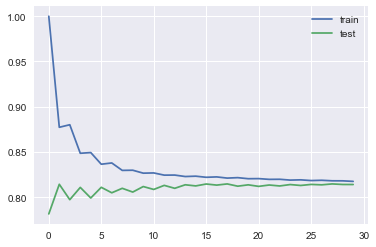

In [18]:
plt.plot(train_score, label="train")
plt.plot(test_score, label="test")
plt.legend()
plt.show()

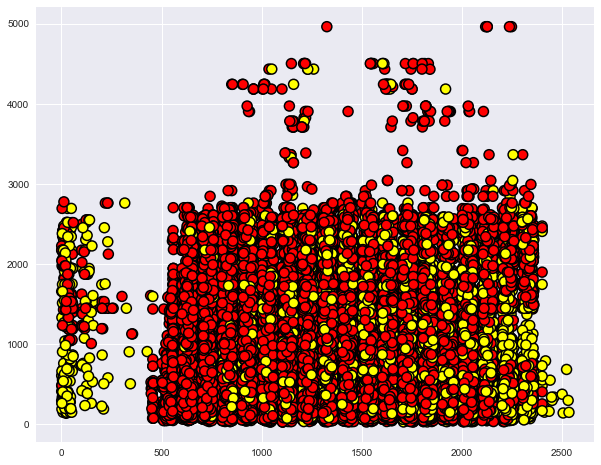

In [19]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(x_train['DepTime'], x_train['Distance'], c=y_train, s=100,
           cmap='autumn',edgecolors='black', linewidth=1.5);

In [20]:
x = pd.get_dummies(x, columns=['UniqueCarrier', 'Origin','Dest'])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, \
                                                    shuffle=True, random_state=18)

In [22]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1) #Классификатор, осуществляющий голосование k-ближайших соседей.
knn.fit(x_train,y_train) #Установите модель с использованием x_train в качестве данных обучения и y_train в качестве целевых значений
prediction = knn.predict(x_test) #Предсказать метки классов для предоставленных данных

#Оценка F1 можно интерпретировать как средневзвешенное значение точности и отзыва, где оценка F1 достигает своего наилучшего значения при 1 и худшем балла в 0.
#F1 = 2 * (precision * recall) / (precision + recall)
print('--------- На ТЕСТЕ ---------')
print('F1 : ',f1_score(y_test,prediction))
print('Точность : ',accuracy_score(y_test, prediction)) #Точность классификации.
print('--------- На ТРЕЙНЕ ---------')
print('F1 : ',f1_score(y_train, knn.predict(x_train)))
print('Точность : ',accuracy_score(y_train, knn.predict(x_train))) #Точность классификации.

--------- На ТЕСТЕ ---------
F1 :  0.22652647113078767
Точность :  0.79035
--------- На ТРЕЙНЕ ---------
F1 :  0.43136547994592167
Точность :  0.842275


In [23]:
# Попробуем применить шкалирвоание данных:
from sklearn.preprocessing import MinMaxScaler

In [25]:
# Возьмем не все признаки
x = table.drop(['dep_delayed_15min', 'UniqueCarrier', 'Origin', 'Dest'], axis=1) 
y = table['dep_delayed_15min'].values

In [26]:
mms = MinMaxScaler()
x = mms.fit_transform(x)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=18)

In [28]:
print('Accuracy: ', cros_val('accuracy', knn, x_train, y_train, 5))
print('Precision: ', cros_val('precision', knn, x_train, y_train, 5))
print('Recall : ', cros_val('recall', knn, x_train, y_train, 5))
print('F1 : ', cros_val('f1', knn, x_train, y_train, 5))

Accuracy:  0.79
Precision:  0.38
Recall :  0.17
F1 :  0.24
